In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Load the data
file_path = '/Users/philiplacava/Projects/Labor Market Demand Forcast/550_project_data.csv'
data1 = pd.read_csv(file_path)


In [3]:
# Create a COVID shock variable: 1 for 2020, 0 otherwise
data1['lockdowns'] = ((data1['year'] == 2020) & (data1['month'] >= 3) & (data1['month'] <= 8)).astype(int)

# there was only yearly data for union membership, so I imputed data. 
# In my origional project I took means for each industry each year, I utilize a different approach in this project 

# union data is collected sporadically over the year, 
# in my data I assume the membership level is accurate at month 4
# this is convinient for aligning up with the start of quarter 2 for imputing out output and union membership drops consistently
data1['u'] = data1.apply(lambda row: row['u'] if row['month'] == 4 else np.nan, axis=1)



# creating date variabel 
data1['date'] = pd.to_datetime(data1[['year', 'month']].assign(DAY=1))

data1.head()

,inflation,inflation_no_f_e,unemployment,total_ui_claims,q_output,industry,jo,u,w,year,...,after_covid,jo_log,u_log,w_log,inflation_log,inflation_fe_log,ui_claims_log,unemployment_log,lockdowns,date
0,231.67900,232.22900,12471,1412000,NaN,1,3467,NaN,24.0,2013,...,0,8.151045,11.586037,3.178054,5.445353,5.447724,14.160518,9.431161,0,2013-01-01
1,232.93700,232.56900,11950,1412000,NaN,1,3584,NaN,24.0,2013,...,0,8.184235,11.586037,3.178054,5.450768,5.449187,14.160518,9.388487,0,2013-02-01
2,232.28200,232.79401,11689,1759000,NaN,1,3681,NaN,24.0,2013,...,0,8.210939,11.586037,3.178054,5.447952,5.450154,14.380256,9.366404,0,2013-03-01
3,231.79700,232.83200,11760,1389000,NaN,1,3566,107585.0,24.0,2013,...,0,8.179200,11.586037,3.178054,5.445862,5.450317,14.144094,9.372459,0,2013-04-01
4,231.89301,232.99600,11654,1391000,NaN,1,3736,NaN,24.0,2013,...,0,8.225771,11.586037,3.178054,5.446276,5.451021,14.145534,9.363404,0,2013-05-01


In [4]:
# inspecting nans
nans_per_column = data1.isna().sum()
print(nans_per_column)

inflation              0
inflation_no_f_e       0
unemployment           0
total_ui_claims        0
q_output            2071
industry               0
jo                     0
u                   2299
w                     11
year                   0
month                  0
after_covid            0
jo_log                 0
u_log                  0
w_log                 11
inflation_log          0
inflation_fe_log       0
ui_claims_log          0
unemployment_log       0
lockdowns              0
date                   0
dtype: int64


In [5]:
# Mapping labels to industry
industry_labels = {
    1: 'Total Private',
    2: 'Accommodations and food services',
    3: 'Arts and entertainment',
    4: 'Construction',
    5: 'Durable Goods Manufacturing',
    6: 'Education (Private Sector)',
    7: 'Financial Activities',
    8: 'Healthcare',
    9: 'Information',
    10: 'Leisure and Hospitality',
    11: 'Mining and Logging',
    12: 'Non Durable Goods Manufacturing',
    13: 'Other Services',
    14: 'Professional & Business Services',
    15: 'Real Estate',
    16: 'Retail Trade',
    17: 'Warehousing, Transportation and Utilities',
    18: 'Transportation',
    19: 'Wholesale Trade',
}
data1['industry'] = data1['industry'].map(industry_labels)

In [6]:
# Mapping colors to industry for plotting
color_mapping = {
    'Total Private': '#000000',  # Black
    'Accommodations and food services': '#FFC0CB',  # Light pink
    'Arts and entertainment': '#FF1493',  # Deep pink
    'Construction': '#A52A2A',  # Brown
    'Durable Goods Manufacturing': '#ff8c00',  # Dark Orange
    'Education (Private Sector)': '#1e90ff',  # Dodger Blue
    'Financial Activities': '#2e8b57',  # Sea Green
    'Healthcare': '#87ceeb',  # Sky Blue
    'Information': '#0000ff',  # Blue
    'Leisure and Hospitality': '#FF69B4',  # Medium pink
    'Mining and Logging': '#ff6347',  # Tomato
    'Non Durable Goods Manufacturing': '#ffa500',  # Orange
    'Other Services': '#808080',  # Grey
    'Professional & Business Services': '#32cd32',  # Lime Green
    'Real Estate': '#3cb371',  # Medium Sea Green
    'Retail Trade': '#9932cc',  # Dark Orchid
    'Warehousing, Transportation and Utilities': '#7851A9',  # Royal Purple
    'Transportation': '#4B0082',  # Indigo
    'Wholesale Trade': '#800080',  # Purple
}

In [7]:
# creating industry groups for plotting

Industry_group1 = [
    'Accommodations and food services',
    'Leisure and Hospitality',
    'Retail Trade',
    'Education (Private Sector)',
    'Healthcare',
    'Professional & Business Services',
    'Warehousing, Transportation and Utilities'
]


industry_group2 = [
    'Mining and Logging',
    'Construction',
    'Durable Goods Manufacturing',
    'Non Durable Goods Manufacturing',
    'Wholesale Trade',
    'Transportation'
]

industry_group3 = [
    'Information',
    'Financial Activities',
    'Real Estate',
    'Arts and entertainment',
    'Other Services'
]


In [8]:

# creating dataframe with imputed data

# Identifying march 2020 as the breaking point in my data. 
breakpoint = pd.to_datetime('2020-03-01')  

before_break = data1[data1['date'] <= breakpoint].reset_index(drop=True)
after_break = data1[data1['date'] > breakpoint].reset_index(drop=True)

def interpolate_group(group, method='spline', order=2, limit_direction='both'):
    return group.interpolate(method=method, order=order, limit_direction=limit_direction)

before_break['u_imputed'] = before_break.groupby('industry')['u'].apply(interpolate_group)
after_break['u_imputed'] = after_break.groupby('industry')['u'].apply(interpolate_group)

before_break['output_imputed'] = before_break.groupby('industry')['q_output'].apply(interpolate_group)
after_break['output_imputed'] = after_break.groupby('industry')['q_output'].apply(interpolate_group)

# imputed dataframe to use throughout
data_imputed = pd.concat([before_break, after_break])



/opt/anaconda3/lib/python3.9/site-packages/scipy/interpolate/fitpack2.py:280: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


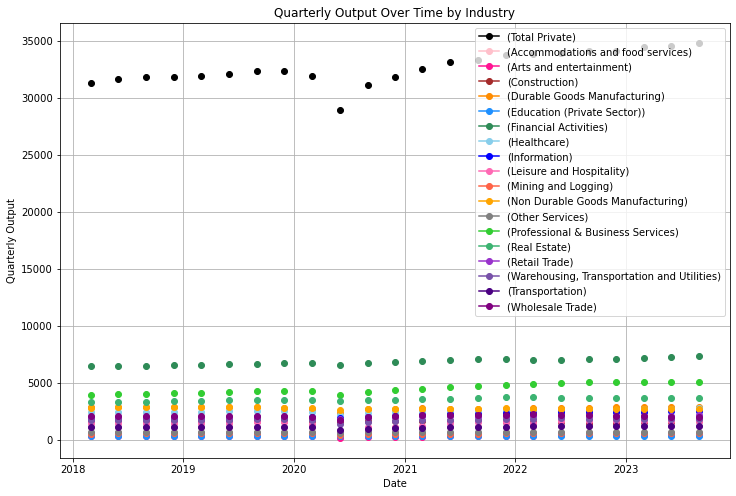

In [9]:
# real quarterly output over time 

plt.figure(figsize=(12, 8))

for industry in data_imputed['industry'].unique():
    industry_data = data_imputed[data_imputed['industry'] == industry]
    plt.plot(industry_data['date'], industry_data['q_output'], marker='o', linestyle='-', label=f'({industry})', color=color_mapping[industry])

plt.title('Quarterly Output Over Time by Industry')
plt.xlabel('Date')
plt.ylabel('Quarterly Output')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# checking imputed dataframe for nulls
data_imputed['output_imputed'] = (data_imputed['output_imputed'])/3
data_imputed['output_imputed_log'] = np.log(data_imputed['output_imputed'])
data_imputed = data_imputed[data_imputed['year'] > 2017]

data_imputed['u_log'] = np.log(data_imputed['u_imputed'])
nans_per_column = data_imputed.isna().sum()
print(nans_per_column)

inflation                0
inflation_no_f_e         0
unemployment             0
total_ui_claims          0
q_output               931
industry                 0
jo                       0
u                     1254
w                       11
year                     0
month                    0
after_covid              0
jo_log                   0
u_log                    0
w_log                   11
inflation_log            0
inflation_fe_log         0
ui_claims_log            0
unemployment_log         0
lockdowns                0
date                     0
u_imputed                0
output_imputed           0
output_imputed_log       0
dtype: int64


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


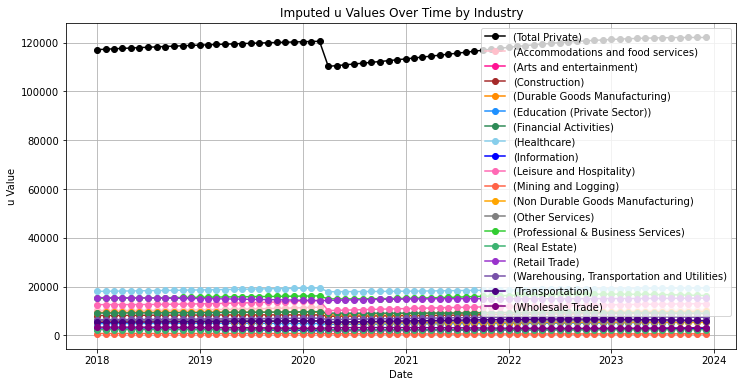

In [11]:
# imputed union membership over time
plt.figure(figsize=(12, 6))
for industry in data_imputed['industry'].unique():
    industry_data = data_imputed[data_imputed['industry'] == industry]
    plt.plot(industry_data['date'], industry_data['u_imputed'], label=f'({industry})', marker='o', color=color_mapping[industry])

plt.title('Imputed u Values Over Time by Industry')
plt.xlabel('Date')
plt.ylabel('u Value')
plt.legend()
plt.grid(True)
plt.show()

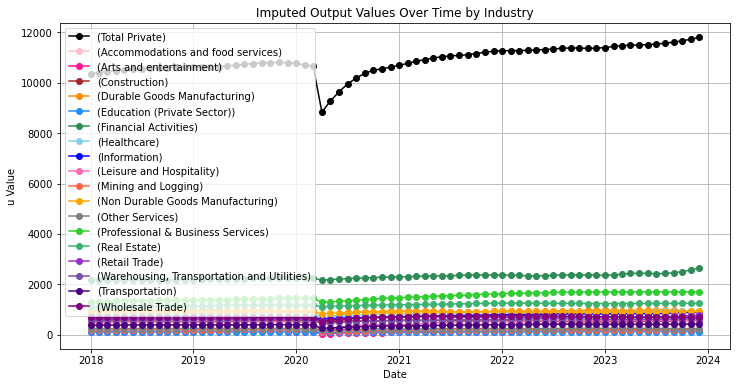

In [12]:
# imputed values for output over time
plt.figure(figsize=(12, 6))
for industry in data_imputed['industry'].unique():
    industry_data2 = data_imputed[data_imputed['industry'] == industry]
    plt.plot(industry_data2['date'], industry_data2['output_imputed'], label=f'({industry})', marker='o', color=color_mapping[industry])

plt.title('Imputed Output Values Over Time by Industry')
plt.xlabel('Date')
plt.ylabel('u Value')
plt.legend()
plt.grid(True)
plt.show()

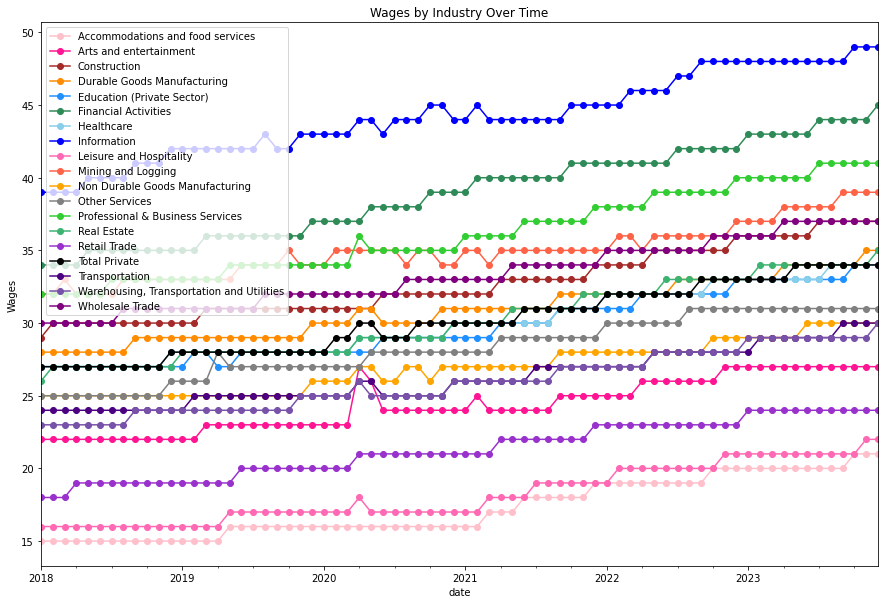

In [13]:
# next I will impute missing values for wages, these missing values are only in one industy,
# and they are not close to the covid outbreak intuition says normal linear interpolation is fine
data_imputed = data_imputed.sort_values(by='date')

# Group by 'industry' and then apply interpolation to each group for the 'w' column
data_imputed['w'] = data_imputed.groupby('industry')['w'].transform(lambda x: x.interpolate())
data_imputed['w_log'] = np.log(data_imputed['w'])


# Set 'time' as the index
data_imputed.set_index('date', inplace=True)

# Plotting
plt.figure(figsize=(15, 10))

# Loop through each industry and plot its wages over time
for industry, group in data_imputed.groupby('industry'):
    # Use the color from color_map for each industry
    color = color_mapping[industry] 
    group['w'].plot(label=industry, color=color, marker='o', legend=True)

plt.title('Wages by Industry Over Time')
plt.xlabel('date')
plt.ylabel('Wages')
plt.legend()
plt.show()



In [14]:
nans_per_column = data_imputed.isna().sum()
print(nans_per_column)

inflation                0
inflation_no_f_e         0
unemployment             0
total_ui_claims          0
q_output               931
industry                 0
jo                       0
u                     1254
w                        0
year                     0
month                    0
after_covid              0
jo_log                   0
u_log                    0
w_log                    0
inflation_log            0
inflation_fe_log         0
ui_claims_log            0
unemployment_log         0
lockdowns                0
u_imputed                0
output_imputed           0
output_imputed_log       0
dtype: int64


In [15]:
# Ensure 'date' is in the correct format and set as index
data_imputed['date'] = pd.to_datetime(data_imputed[['year', 'month']].assign(DAY=1))
data_imputed.set_index('date', inplace=True)

# Check and sort the index
data_imputed.sort_index(inplace=True)

# Verify if there are any missing months
expected_range = pd.date_range(start=data_imputed.index.min(), end=data_imputed.index.max(), freq='MS')
missing_months = expected_range.difference(data_imputed.index)
print("Missing months:", missing_months)

Missing months: DatetimeIndex([], dtype='datetime64[ns]', freq=None)


In [16]:
# creating differenced variables for time series
data_imputed['diff_unemployment_log'] = data_imputed['unemployment_log'].diff(1)
data_imputed['diff_inflation_log'] = data_imputed['inflation_log'].diff(1)
data_imputed['diff_w_log'] = data_imputed['w_log'].diff(1)

data_imputed.head(20)



,inflation,inflation_no_f_e,unemployment,total_ui_claims,q_output,industry,jo,u,w,year,...,inflation_fe_log,ui_claims_log,unemployment_log,lockdowns,u_imputed,output_imputed,output_imputed_log,diff_unemployment_log,diff_inflation_log,diff_w_log
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,248.85899,255.20399,6489,941000,NaN,Total Private,6029,NaN,27.0,2018,...,5.542063,13.754699,8.777864,0,117115.662041,10367.129851,9.246395,NaN,NaN,NaN
2018-01-01,248.85899,255.20399,6489,941000,NaN,Construction,250,NaN,29.0,2018,...,5.542063,13.754699,8.777864,0,8097.839095,530.166112,6.273190,0.000000,0.000000,0.071459
2018-01-01,248.85899,255.20399,6489,941000,NaN,Wholesale Trade,208,NaN,30.0,2018,...,5.542063,13.754699,8.777864,0,3349.195685,692.091611,6.539718,0.000000,0.000000,0.033902
2018-01-01,248.85899,255.20399,6489,941000,NaN,Durable Goods Manufacturing,267,NaN,28.0,2018,...,5.542063,13.754699,8.777864,0,9347.571918,970.869672,6.878192,0.000000,0.000000,-0.068993
2018-01-01,248.85899,255.20399,6489,941000,NaN,Education (Private Sector),1154,NaN,27.0,2018,...,5.542063,13.754699,8.777864,0,4773.814139,119.387249,4.782372,0.000000,0.000000,-0.036368
2018-01-01,248.85899,255.20399,6489,941000,NaN,Financial Activities,389,NaN,34.0,2018,...,5.542063,13.754699,8.777864,0,9119.313176,2174.753673,7.684671,0.000000,0.000000,0.230524
2018-01-01,248.85899,255.20399,6489,941000,NaN,Healthcare,1046,NaN,27.0,2018,...,5.542063,13.754699,8.777864,0,18021.943618,806.545221,6.692760,0.000000,0.000000,-0.230524
2018-01-01,248.85899,255.20399,6489,941000,NaN,Transportation,279,NaN,24.0,2018,...,5.542063,13.754699,8.777864,0,5352.246936,373.387524,5.922617,0.000000,0.000000,-0.117783
2018-01-01,248.85899,255.20399,6489,941000,NaN,Information,128,NaN,39.0,2018,...,5.542063,13.754699,8.777864,0,2532.336761,610.375580,6.414074,0.000000,0.000000,0.485508


In [17]:
# imposing 0 on nans
data_imputed['diff_unemployment_log'].fillna(0, inplace=True)
data_imputed['diff_inflation_log'].fillna(0, inplace=True)
data_imputed['diff_w_log'].fillna(0, inplace=True)


In [18]:
# adf test for stationarity
variables_to_test = ['jo', 'w', 'output_imputed', 'u_imputed', 'diff_inflation_log', 'unemployment_log']  # List your variables here

adf_results = {}

for variable in variables_to_test:
    series = data_imputed[variable].dropna()  
    adf_test_result = adfuller(series)

    adf_results[variable] = {
        'ADF Statistic': adf_test_result[0],
        'p-value': adf_test_result[1],
        'Critical Values': adf_test_result[4],
    }

# Display the ADF test results for each variable
for variable, result in adf_results.items():
    print(f"Results for {variable}:")
    print(f"ADF Statistic: {result['ADF Statistic']}")
    print(f"p-value: {result['p-value']}")
    for key, value in result['Critical Values'].items():
        print(f"Critical Value ({key}): {value}")
    print()


Results for jo:
ADF Statistic: -5.6213967337906485
p-value: 1.1429423642792444e-06
Critical Value (1%): -3.435224876159216
Critical Value (5%): -2.863692881297647
Critical Value (10%): -2.567916197938811

Results for w:
ADF Statistic: -2.7493706006086334
p-value: 0.06587764281271541
Critical Value (1%): -3.43522851297339
Critical Value (5%): -2.8636944861078013
Critical Value (10%): -2.5679170525584523

Results for output_imputed:
ADF Statistic: -12.573769539893794
p-value: 1.9778708138654114e-23
Critical Value (1%): -3.4352067731212785
Critical Value (5%): -2.863684892975246
Critical Value (10%): -2.5679119438718847

Results for u_imputed:
ADF Statistic: -12.867149039432011
p-value: 4.967302133241104e-24
Critical Value (1%): -3.4352067731212785
Critical Value (5%): -2.863684892975246
Critical Value (10%): -2.5679119438718847

Results for diff_inflation_log:
ADF Statistic: -4.220589967466758
p-value: 0.0006079707854299279
Critical Value (1%): -3.4352067731212785
Critical Value (5%): -2

In [23]:
forecasts = {}
for industry in data_imputed['industry'].unique():
    industry_data = data_imputed[data_imputed['industry'] == industry]
    industry_data = industry_data.sort_index()
    # Set the frequency of the index to 'MS' (month start)
    industry_data = industry_data.asfreq('MS')
    
    y = industry_data['jo']  # Dependent variable (job openings)
    X = industry_data[['w','u_imputed', 'output_imputed_log', 'unemployment_log', 'diff_inflation_log']]  # Independent variables u_imputed = union membership

    # Fit a SARIMA model
    model = SARIMAX(y, exog=X, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results = model.fit(maxiter=500, disp=False)  # Fit the model quietly
    
    # Forecast for the next 12 months
    forecast = results.get_forecast(steps=12, exog=X[-12:])
    forecasts[industry] = forecast.predicted_mean  # Store the forecasted values
    
    print(f"Summary for {industry} industry:")
    print(results.summary())
    print("\n")



Summary for Total Private industry:
                                     SARIMAX Results                                      
Dep. Variable:                                 jo   No. Observations:                   72
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -441.277
Date:                            Mon, 18 Mar 2024   AIC                            902.553
Time:                                    10:49:39   BIC                            923.329
Sample:                                01-01-2018   HQIC                           910.663
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
w                    -66.4139    183.589     -0.362      0.718

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Summary for Financial Activities industry:
                                     SARIMAX Results                                      
Dep. Variable:                                 jo   No. Observations:                   72
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -333.399
Date:                            Mon, 18 Mar 2024   AIC                            686.799
Time:                                    10:49:44   BIC                            707.574
Sample:                                01-01-2018   HQIC                           694.909
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
w                    -14.0180     27.213     -0.515    

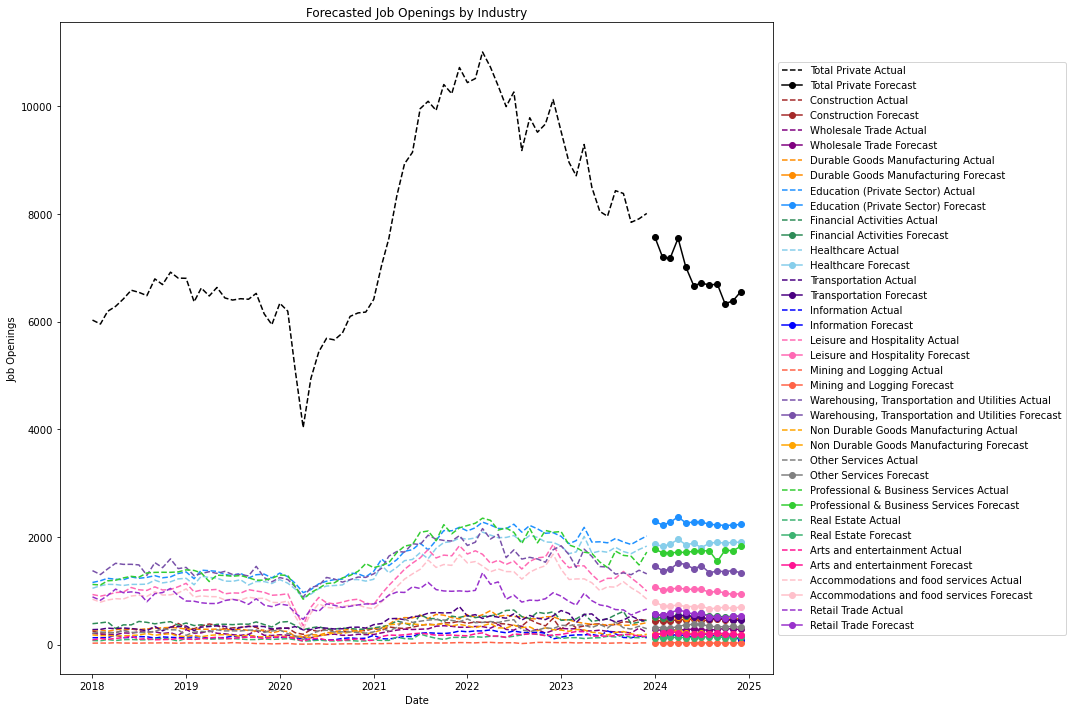

In [20]:
# plotting forcast
last_historical_date = data_imputed.index.max()
forecast_dates = pd.date_range(start=last_historical_date, periods=13, freq='MS')[1:]  # Get the next 12 months

plt.figure(figsize=(15, 10))

for industry, forecast in forecasts.items():
    if industry in data_imputed['industry'].unique() and 'jo' in data_imputed.columns:
        industry_data = data_imputed[data_imputed['industry'] == industry]
        industry_data = industry_data.sort_index().asfreq('MS')
        color = color_mapping.get(industry, 'grey')  # Default to grey if the industry is not in the color_mapping

        # Plot actual historical data
        plt.plot(industry_data.index, industry_data['jo'], label=f'{industry} Actual', linestyle='dashed', color=color)

        # Plot forecast
        plt.plot(forecast_dates, forecast, label=f'{industry} Forecast', marker='o', color=color)

plt.title('Forecasted Job Openings by Industry')
plt.xlabel('Date')
plt.ylabel('Job Openings')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  # Adjust the plot to ensure the legend and labels fit well
plt.show()



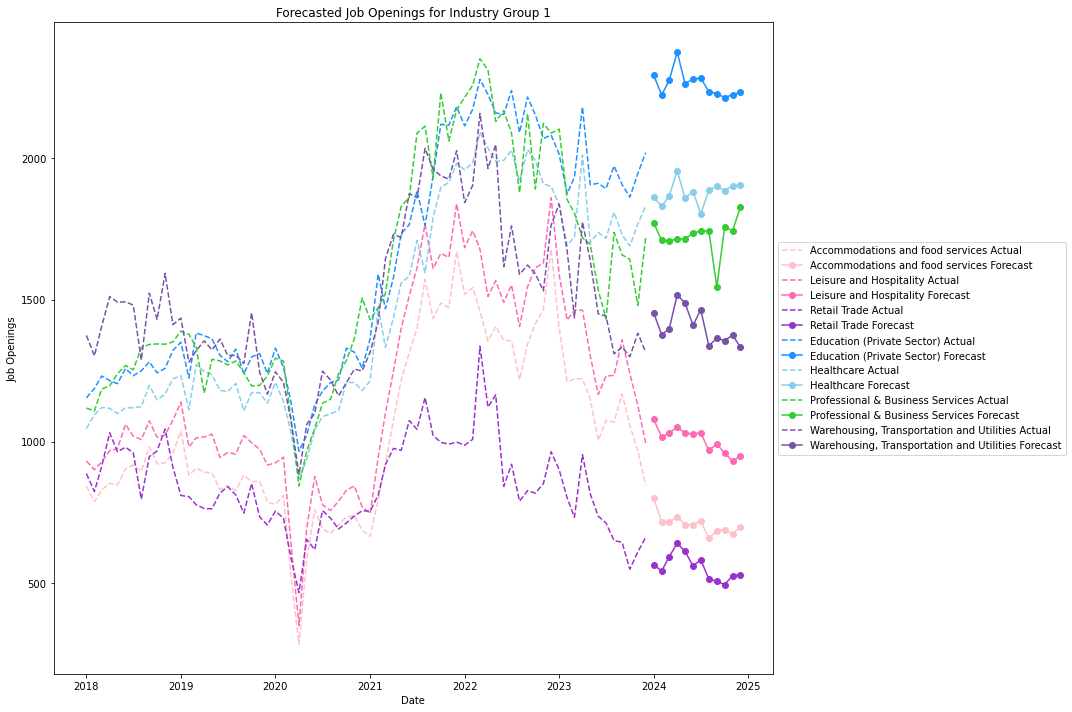

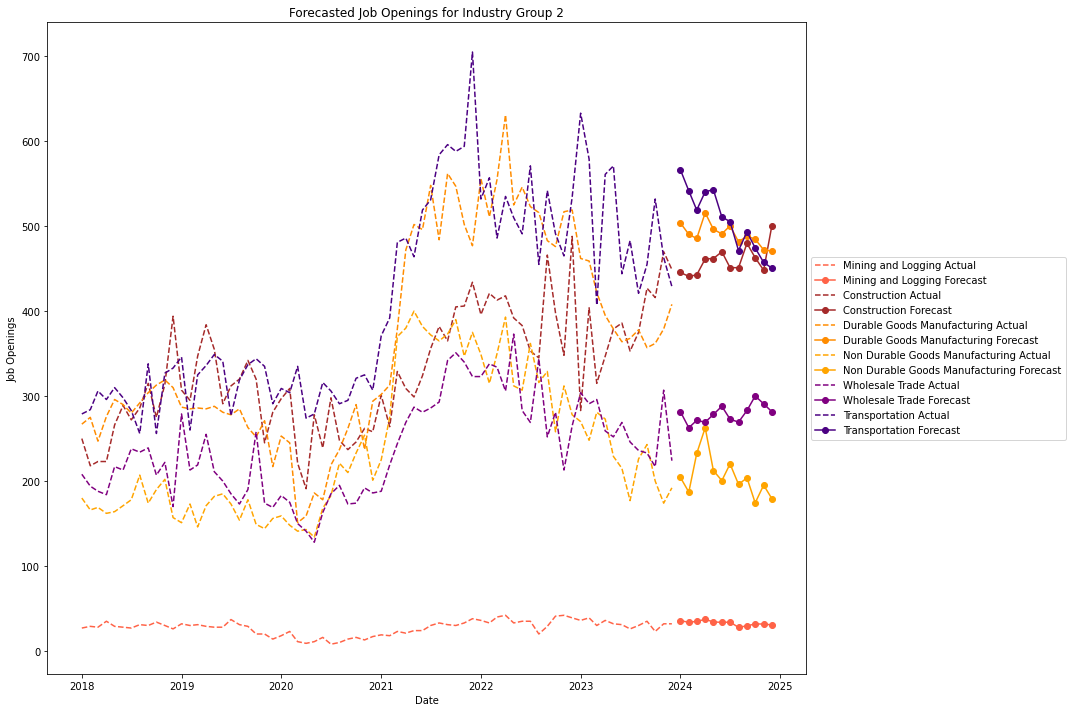

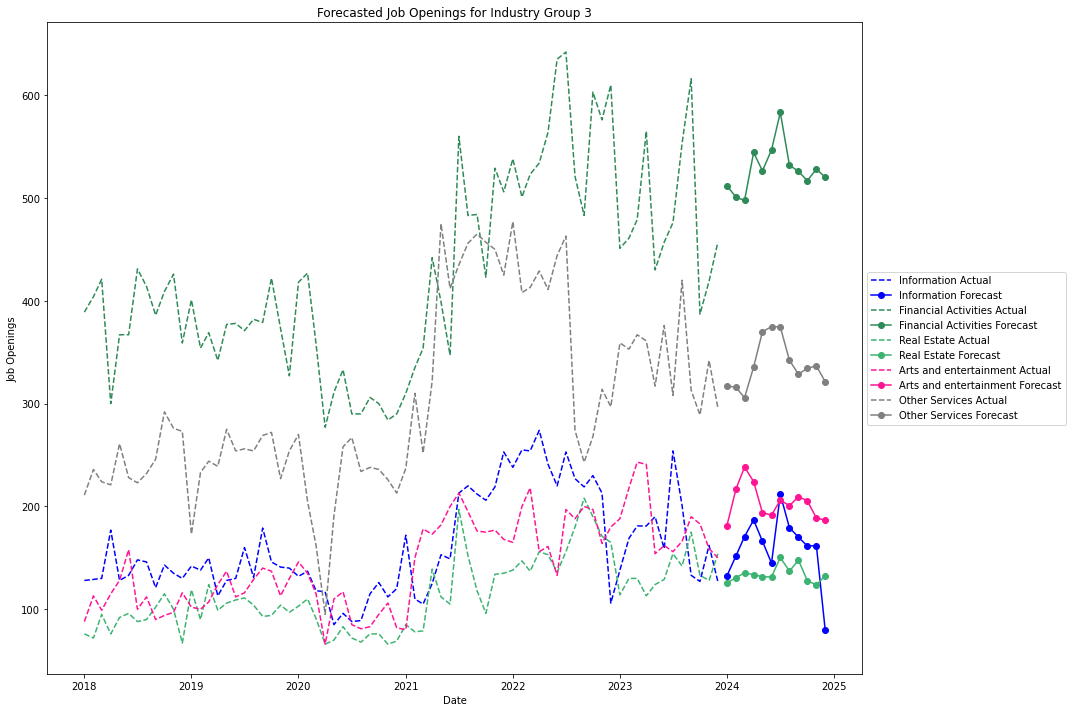

In [21]:
# Function to plot a given industry group
def plot_industry_group(industry_group, group_number):
    plt.figure(figsize=(15, 10))
    
    for industry in industry_group:
        if industry in forecasts:
            forecast = forecasts[industry]
            industry_data = data_imputed[data_imputed['industry'] == industry].sort_index().asfreq('MS')

            color = color_mapping.get(industry, 'grey')  

            # Plot actual historical data
            plt.plot(industry_data.index, industry_data['jo'], label=f'{industry} Actual', linestyle='dashed', color=color)

            # Plot forecast 
            plt.plot(forecast_dates, forecast, label=f'{industry} Forecast', marker='o', color=color)

    plt.title(f'Forecasted Job Openings for Industry Group {group_number}')
    plt.xlabel('Date')
    plt.ylabel('Job Openings')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()  # Adjust the plot to ensure the legend and labels fit well
    plt.show()

# Plot each industry group
plot_industry_group(Industry_group1, 1)
plot_industry_group(industry_group2, 2)
plot_industry_group(industry_group3, 3)